## Run MCMC inference using PriorCVAE model

In [1]:
import random
import time
import pickle
import yaml
import os

import flax.linen as nn
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.utility import load_model_params
from priorCVAE.models import MLPDecoder
from experiments.zimbabwe.zimbabwe_utility import read_data

In [2]:
data_path = "../data/zwe2016phia.geojson"

prior_vae_model_path = r"../outputs/2023-10-05/18-05-26/"
model = None
conditional = False
latent_dim = -1

num_warmup = 2000
num_samples = 10000
num_chains = 2


## Load Data

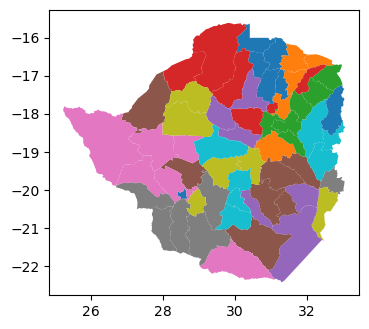

In [3]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [14]:
x, data_centroid = read_data(data_path, normalize=True)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [15]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

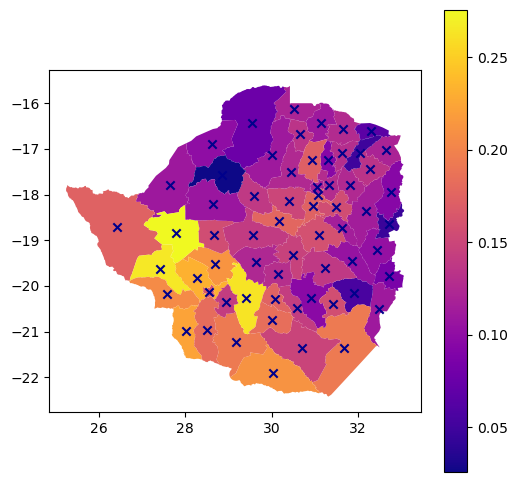

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [7]:
def load_priorvae_model():
    cfg_path = os.path.join(prior_vae_model_path, ".hydra", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    conditional = cfg_data["conditional"]
    latent_dim = cfg_data["latent_dim"]
    dec_activation_fn = cfg_data["dec_activation"]["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
    
    trained_decoder_params = load_model_params(os.path.join(prior_vae_model_path, "model"))["decoder"]
    
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)
    
    return decoder, conditional, latent_dim, trained_decoder_params

In [8]:
model, conditional, latent_dim, trained_decoder_params = load_priorvae_model()

In [9]:
def get_decoder_sample(model, z, c):
    if model is None:
        model = load_priorvae_model()
    
    z = z.reshape((1, -1))
    c = c.reshape((1, 1))
    z_c = jnp.concatenate([z, c], axis=-1)
    
    out =  model.apply({'params': trained_decoder_params}, z_c)
    
    return out

In [10]:
def model_centroids_vae(model, x, n_obs=None, lengthscale=None, y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
    
    if conditional:  
        c = numpyro.sample("c", npdist.Gamma(2,4)) 
        
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    
    vae_output = get_decoder_sample(model, z, c)
    
    re_std_vae = numpyro.deterministic("re_std_vae", vae_output)        
    kernel_var = numpyro.sample("kernel_var", npdist.Gamma(1.5, 1.5)) 
    re_vae = numpyro.deterministic('re_vae', kernel_var * re_std_vae)
    
    # linear predictor
    lp = b0 + re_vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
     
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

## Observations

In [11]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## Prior

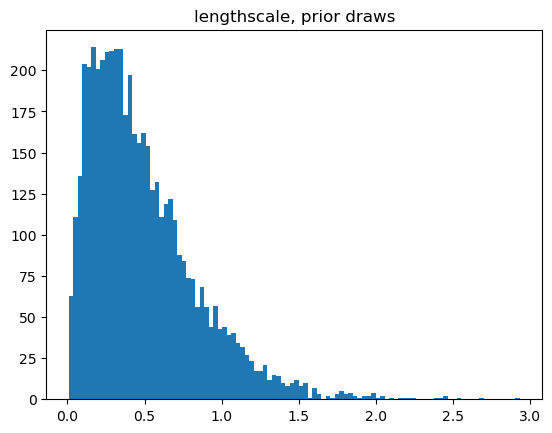

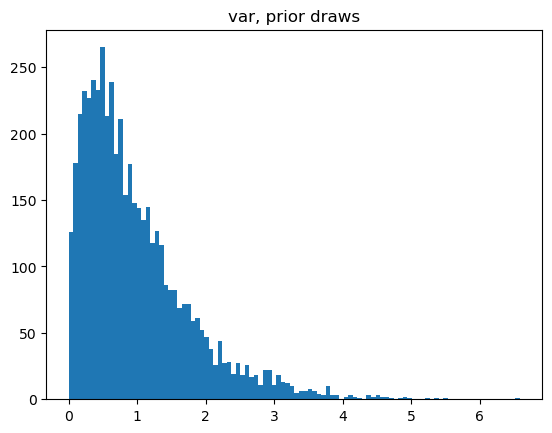

In [13]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_centroids_vae, num_samples=5000)
gp_preds = gp_predictive(rng_key_, model=model, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['c']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['kernel_var']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

In [ ]:
fname = 'zimbabwe_priorcvae_mcmc.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_centroids)
mcmc_vae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_vae.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

In [ ]:
with open(fname, 'wb') as f:
    pickle.dump(mcmc_vae, f)

In [ ]:
mcmc_vae.print_summary(exclude_deterministic=False)
mcmc_vae_samples = mcmc_vae.get_samples()

In [ ]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))

In [ ]:
c_samps_vae = mcmc_vae_samples['c']
plt.hist(c_samps_vae, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('lengthscale, prior and posterior')
plt.legend()

In [ ]:
var_samps_vae = mcmc_vae_samples['variance']
plt.hist(var_samps_vae, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'proir', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)